# How to compute and plot the volume of the brain substructures?

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

import polpo.preprocessing.dict as ppdict
import polpo.preprocessing.pd as ppd
from polpo.preprocessing import IndexMap, NestingSwapper
from polpo.preprocessing.load.fsl import get_all_first_structs
from polpo.preprocessing.load.pregnancy.jacobs import MeshLoader

## Loading meshes

In [ ]:
structs = get_all_first_structs(include_brstem=False, order=True)

In [2]:
subject_id = "01"

mesh_loader = (
    MeshLoader(
        subject_subset=[subject_id],
        struct_subset=structs,
        as_mesh=True,
    )
    + ppdict.ExtractUniqueKey()
    + ppdict.NestedDictSwapper()
)

## Loading tabular data

In [3]:
pilot = subject_id == "01"

pipe = DenseMaternalCsvDataLoader(pilot=pilot, subject_id=subject_id)

df = pipe()

Here, we filter the tabular data.

In [4]:
session_selector = ppd.DfIsInFilter("stage", ["post"], negate=True)

predictor_selector = (
    session_selector + ppd.ColumnsSelector("gestWeek") + ppd.SeriesToDict()
)

In [5]:
x_dict = predictor_selector(df)

## Plot results

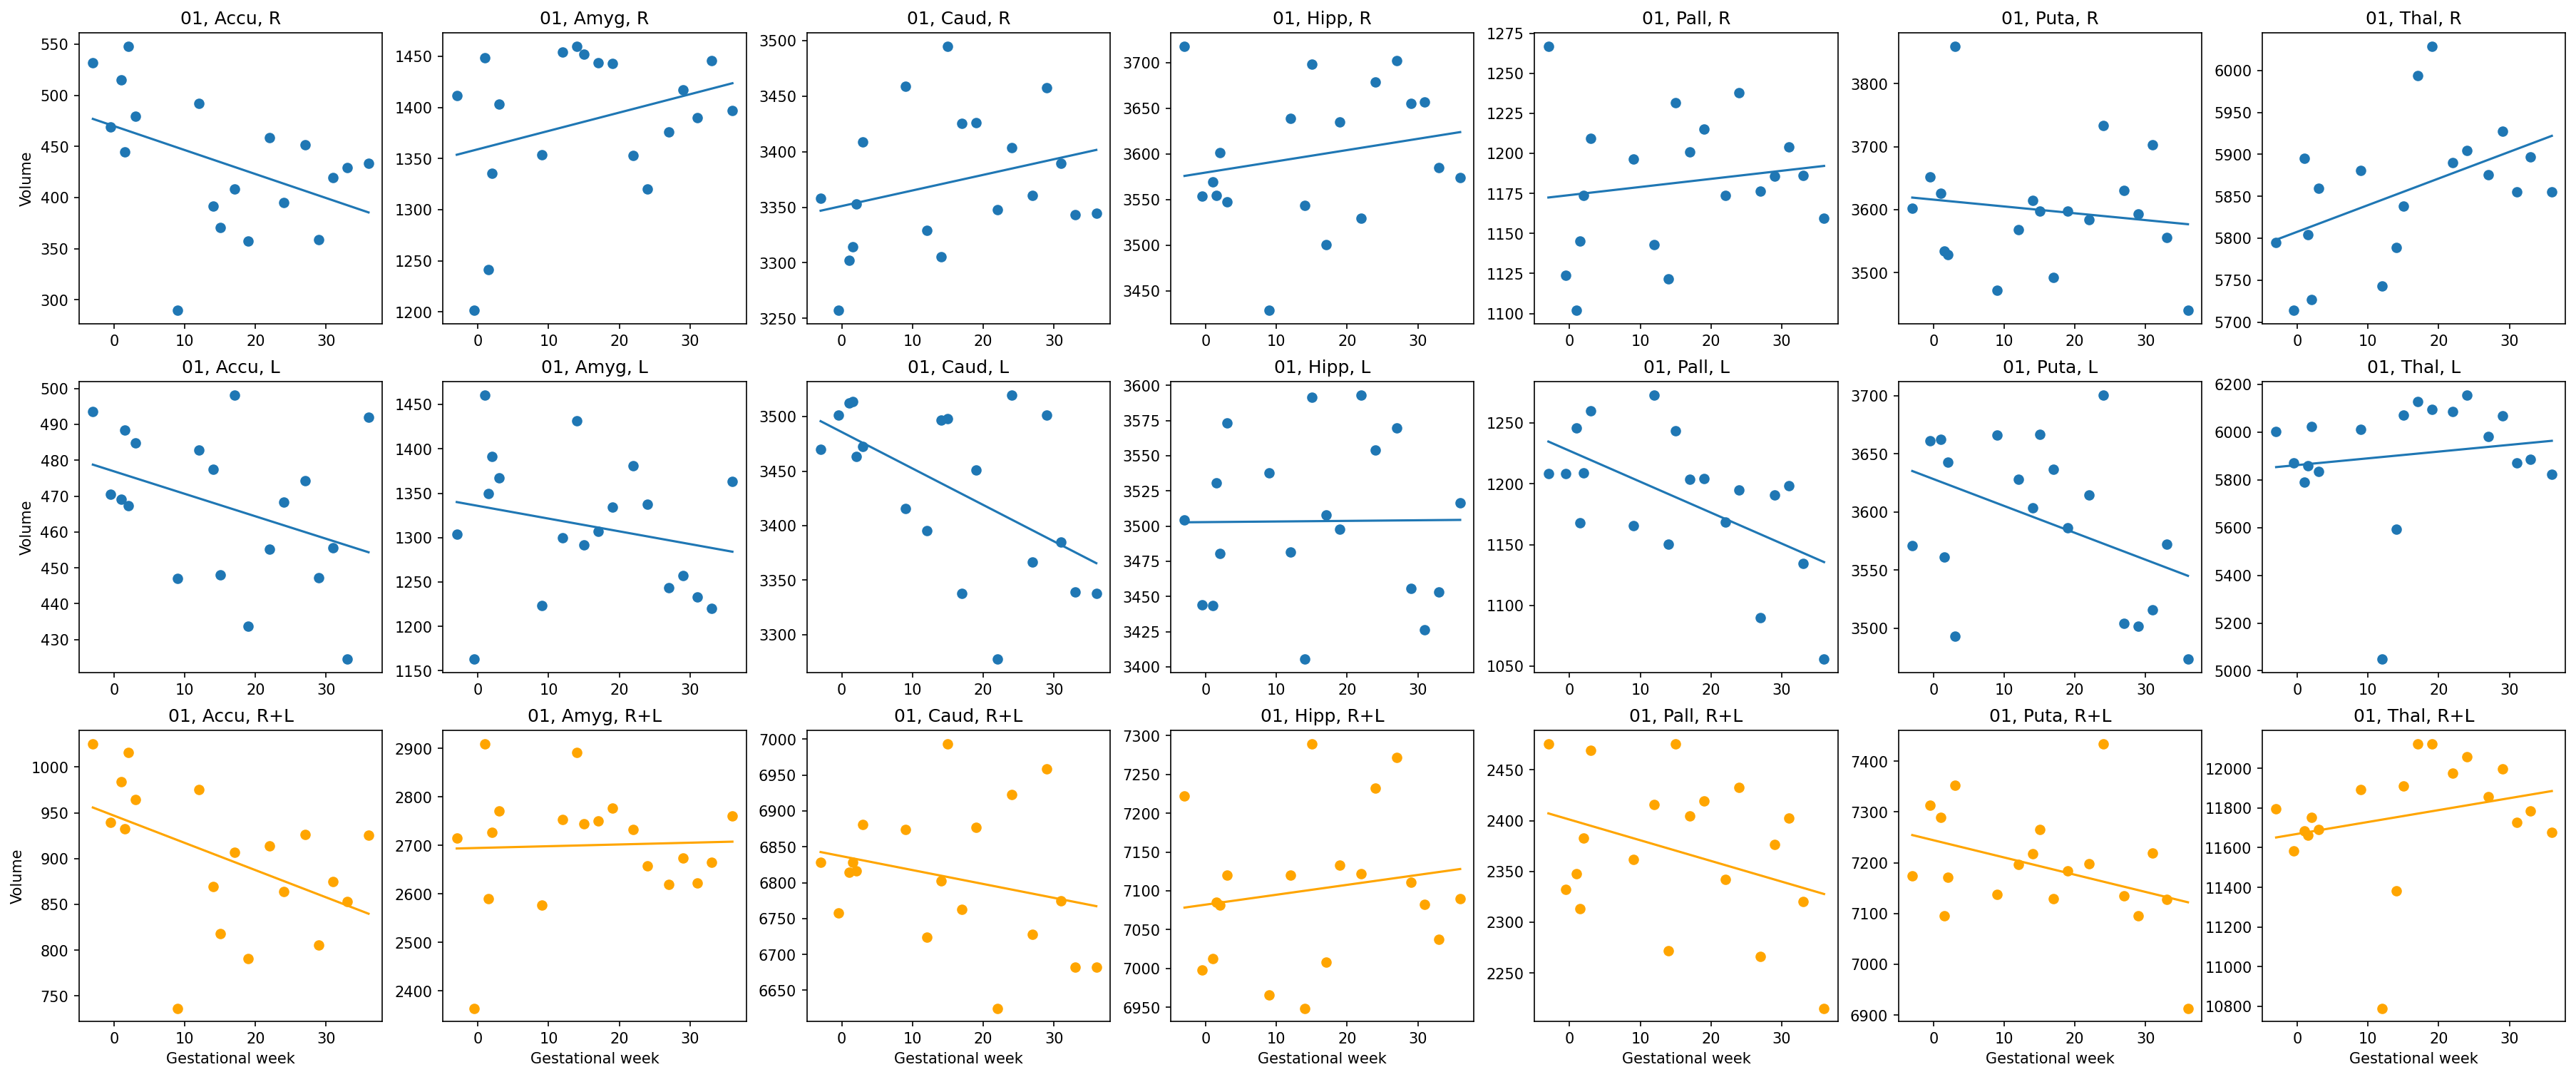

In [6]:
_, axes = plt.subplots(
    nrows=2 + 1,
    ncols=len(FIRST_STRUCTS),
    sharex=False,
    sharey=False,
    squeeze=True,
    figsize=(30, 12),
    dpi=150,
)

dataset_pipe = (
    DictMerger() + NestingSwapper() + IndexMap(lambda x: np.array(x), index=0)
)
model = LinearRegression(fit_intercept=True)


for left, meshes_structs in meshes.items():
    side_name = "L" if left else "R"
    for pos, (struct, meshes_struct) in enumerate(meshes_structs.items()):
        ax = axes[int(left)][pos]

        x, meshes_ = dataset_pipe((x_dict, meshes_struct))

        volumes = [mesh.volume for mesh in meshes_]

        model.fit(x[:, None], volumes)

        x_pred = np.linspace(min(x), max(x))

        ax.scatter(x, volumes)
        ax.plot(x_pred, model.predict(x_pred[:, None]))

        if pos == 0:
            ax.set_ylabel("Volume")

        ax.set_title(f"{subject_id}, {struct}, {side_name}")

# L + R
for pos, struct in enumerate(FIRST_STRUCTS):
    ax = axes[2][pos]

    x, meshes_left, meshes_right = dataset_pipe(
        (x_dict, meshes[True][struct], meshes[False][struct])
    )
    volumes = [
        left_mesh.volume + right_mesh.volume
        for left_mesh, right_mesh in zip(meshes_left, meshes_right)
    ]

    model.fit(x[:, None], volumes)

    x_pred = np.linspace(min(x), max(x))

    ax.scatter(x, volumes, color="orange")
    ax.plot(x_pred, model.predict(x_pred[:, None]), color="orange")

    if pos == 0:
        ax.set_ylabel("Volume")

    ax.set_xlabel("Gestational week")
    ax.set_title(f"{subject_id}, {struct}, R+L")